In [ ]:
import pickle
import pandas as pd
import numpy as np

import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
with open("raw_user_profiles", "rb") as raw_timeline_file:
    user_df = pd.read_pickle(raw_timeline_file)

with open("raw_tweets", "rb") as raw_timeline_file:
    tweet_df = pd.read_pickle(raw_timeline_file)

pd.set_option('display.max_colwidth', None)

In [4]:
# select tweets with hashtags
tweet_df['hashtag_len'] = tweet_df['hashtags'].apply(len)
with_tags = tweet_df[tweet_df['hashtag_len'] > 0]

print(f'there are a total of {len(with_tags)} tweets with hashtags')
print(f'the percentage of tweets with hashtags out of total tweets is {len(with_tags)/len(tweet_df):.2%}')

there are a total of 1328105 tweets with hashtags
the percentage of tweets with hashtags out of total tweets is 25.14%


In [ ]:
# preprocess tweets
def clean(tweet):
    temp = re.sub(r"(http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    temp = re.sub(r'\s*\b(?:https?:\/\/)?(?:www\.)?\S+\.(com|org|gov)\S*\b', ' ', temp)  # remove com/org/gov links
    temp = re.sub(r'\bbit\.ly\/\S*', '', temp) #remove bit.ly links
    temp = re.sub(r'\bow\.ly\/\S*', '', temp) #remove ow.ly links
    temp = re.sub(r'\B@\w+', '@username', temp) #replace user mention with "@username"
    temp = re.sub(r'\#\w+', '', temp) #remove hashtags
    return temp
with_tags['tweet_cleaned'] = with_tags['content'].apply(clean)

# expand tweets with multiple hashtags into multiple rows
with_tags = with_tags.explode('hashtags')

In [6]:
# there is a total of 168,101 unique hashtags used, the vast majority of them are only used a couple of times
hashtag_freq = with_tags.groupby('hashtags', as_index = False)['id'].count().sort_values(by=['id'], ascending=False)
hashtag_freq.columns = ['hashtags', 'frequency']
hashtag_freq['frequency'].describe()

count    161801.000000
mean         11.665632
std         146.709016
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max       33100.000000
Name: frequency, dtype: float64

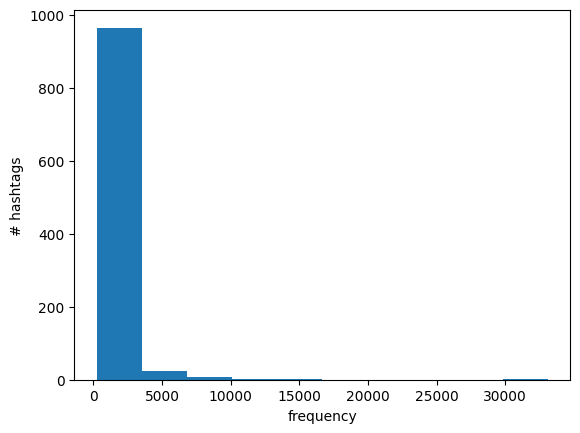

In [7]:
# even among the top 1000 most frequent hashtags, a small number of them are much more popular than the rest
import matplotlib.pyplot as plt
plt.hist(hashtag_freq.iloc[:1000]['frequency'])
plt.xlabel('frequency')
plt.ylabel('# hashtags')
plt.show()

In [8]:
# select the most popular hashtags
high_freq_tags = hashtag_freq[hashtag_freq['frequency'] >= 5000]
high_freq_tags

,hashtags,frequency
17415,COVID19,33100
92604,SOTU,15338
155601,tcot,10472
3029,ACA,10398
37537,ForThePeople,9506
91641,SCOTUS,8994
76986,Obamacare,8259
6893,AmericanRescuePlan,8240
15257,BuildBackBetter,8086
106055,TheLead,7724


In [9]:
# from tweets with the most popular hashtags, sample an equal number of tweets from each hashtag
tweets_with_high_freq_tags = pd.merge(with_tags, high_freq_tags,on='hashtags')
tweet_sampled = tweets_with_high_freq_tags.groupby('hashtags', group_keys=False).apply(lambda x: x.sample(n=3000, replace=False))

In [10]:
tweet_sampled = tweet_sampled.dropna(subset=['tweet_cleaned'])
tweet_sampled['tweet_len'] = tweet_sampled['tweet_cleaned'].map(lambda x: len(word_tokenize(x)))
tweet_sampled['tweet_len'].describe()

count    54000.000000
mean        28.527111
std         13.343716
min          0.000000
25%         18.000000
50%         25.000000
75%         40.000000
max         79.000000
Name: tweet_len, dtype: float64

In [11]:
# remove tweets that are too short
tweet_sampled = tweet_sampled[tweet_sampled['tweet_len']>=10]

In [ ]:
# use CANINE (a character-level encoding model) on lightly preprocessed tweets to predict their hashtags
from transformers import AutoTokenizer, CanineForSequenceClassification
num_labels = len(high_freq_tags)
tokenizer = AutoTokenizer.from_pretrained("google/canine-s")
model = CanineForSequenceClassification.from_pretrained("google/canine-s",\
                                                        num_labels=num_labels,\
                                                        problem_type="multi_label_classification")

In [13]:
# encode labels (hashtags) into numeric values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded_label = le.fit_transform(high_freq_tags['hashtags'])
label_lookup = pd.DataFrame({'encoded_label': encoded_label, 'true_label': le.inverse_transform(encoded_label)})

In [14]:
tweet_sampled = tweet_sampled.merge(label_lookup, left_on ='hashtags', right_on='true_label', how='left')
tweet_sampled = tweet_sampled[['content','tweet_cleaned','encoded_label', 'true_label']]

In [15]:
# find the longest tokenized sequence length in the dataset
encoding = tokenizer(tweet_sampled['tweet_cleaned'].tolist(), padding="longest",\
                     add_special_tokens = False, return_tensors="pt")
MAX_LENGTH = encoding['input_ids'].shape[1]

In [16]:
MAX_LENGTH

308

In [17]:
# split data into 80% train, 20% validation and apply tokenizer on train_set and val_set
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(tweet_sampled, test_size=0.2, random_state=42)
train_set_enc = tokenizer(train_set['tweet_cleaned'].tolist(), padding=True,\
                      max_length = MAX_LENGTH, truncation = True, \
                     add_special_tokens = False, return_tensors="pt")
val_set_enc = tokenizer(val_set['tweet_cleaned'].tolist(), padding=True,\
                      max_length = MAX_LENGTH, truncation = True, \
                     add_special_tokens = False, return_tensors="pt")

In [18]:
# prepare data for training
import torch
from torch.utils.data import Dataset, DataLoader
class TwitterDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
     
    def __len__(self):
        return len(self.labels)

In [19]:
train_dataset = TwitterDataset(train_set_enc, train_set['encoded_label'].tolist())
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
val_dataset = TwitterDataset(val_set_enc, val_set['encoded_label'].tolist())
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [20]:
# model training
from tqdm import tqdm
from transformers import AdamW
import torch.nn.functional as nnF

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

optim = AdamW(model.parameters(), lr=1e-4)

for epoch in range(10):
  train_loss = 0
  counter = 0

  for idx, batch in tqdm(enumerate(train_loader), total=len(train_loader)):

    optim.zero_grad()
    input_ids = batch['input_ids'].to(device)
    token_type_ids = batch['token_type_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device) 
    one_hot_labels = nnF.one_hot(labels, num_classes=num_labels).float()

    loss = model(input_ids=input_ids,\
               token_type_ids=token_type_ids,\
               attention_mask=attention_mask,\
               labels=one_hot_labels).loss

    train_loss += loss
    counter += 1
    loss.backward()
    optim.step()
    torch.cuda.empty_cache()
  
  print(f'epoch {epoch} loss =======> {train_loss/counter}')

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/327 [00:00<?, ?it/s]<ipython-input-18-8ed059976f70>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 327/327 [03:13<00:00,  1.69it/s]


epoch 0 loss =======> 0.21045610308647156


100%|██████████| 327/327 [03:05<00:00,  1.76it/s]


epoch 1 loss =======> 0.13764545321464539


100%|██████████| 327/327 [03:05<00:00,  1.76it/s]


epoch 2 loss =======> 0.10603442788124084


100%|██████████| 327/327 [03:05<00:00,  1.76it/s]


epoch 3 loss =======> 0.08853109180927277


100%|██████████| 327/327 [03:06<00:00,  1.76it/s]


epoch 4 loss =======> 0.07531439512968063


100%|██████████| 327/327 [03:05<00:00,  1.76it/s]


epoch 5 loss =======> 0.06495903432369232


100%|██████████| 327/327 [03:05<00:00,  1.76it/s]


epoch 6 loss =======> 0.057270348072052


100%|██████████| 327/327 [03:06<00:00,  1.76it/s]


epoch 7 loss =======> 0.051099441945552826


100%|██████████| 327/327 [03:06<00:00,  1.76it/s]


epoch 8 loss =======> 0.04488616809248924


100%|██████████| 327/327 [03:05<00:00,  1.76it/s]

epoch 9 loss =======> 0.04090004041790962


In [21]:
# validation
model.eval()
total_loss = 0
correct_predictions = 0
total_predictions = 0
counter = 0
predictions = []

with torch.no_grad():
  for idx, batch in tqdm(enumerate(val_loader), total=len(val_loader)):

    input_ids = batch['input_ids'].to(device)
    token_type_ids = batch['token_type_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device) 
    one_hot_labels = nnF.one_hot(labels, num_classes=num_labels).float()
  
    logits = model(input_ids = input_ids,\
                 token_type_ids = token_type_ids,\
                 attention_mask= attention_mask).logits
    loss = model(input_ids=input_ids,\
               token_type_ids=token_type_ids,\
               attention_mask=attention_mask,\
               labels=one_hot_labels).loss
    probs = nnF.softmax(logits, dim=1)
    predicted_labels = probs.argmax(1)
  
    predictions.extend(predicted_labels.tolist())
    total_loss += loss.item()
    correct_predictions += (predicted_labels == labels).type(torch.float).sum().item()
    total_predictions += len(labels)
    counter += 1

print(f'validation loss =======> {total_loss/counter:.4f}')
print(f'validation accuracy =======> {correct_predictions/total_predictions:.4f}')

  0%|          | 0/82 [00:00<?, ?it/s]<ipython-input-18-8ed059976f70>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 82/82 [00:31<00:00,  2.58it/s]

validation loss =======> 0.1190
validation accuracy =======> 0.6519


In [31]:
# print sample predictions
val_set['predicted_labels'] = predictions
val_predictions = val_set.merge(label_lookup, left_on = 'predicted_labels', right_on = 'encoded_label', how = 'left')
val_predictions = val_predictions[['content', 'tweet_cleaned','true_label_x','true_label_y']]
val_predictions.columns = ['original_tweet', 'cleaned_tweet', 'true_hashtag', 'predicted_hashtag']
val_predictions.sample(10)

,original_tweet,cleaned_tweet,true_hashtag,predicted_hashtag
4400,"Where is @POTUS plan to defeat radical Islamic terrorism? Oh wait, he doesn't have one... #SOTU #LastSOTU","Where is @username plan to defeat radical Islamic terrorism? Oh wait, he doesn't have one...",SOTU,tcot
3480,Make sure you're subscribed to my YouTube channel --&gt; youtube.com/user/MarioDiaz… #sayfie #tcot #latism,Make sure you're subscribed to my YouTube channel --&gt; …,tcot,tcot
2979,"I helped secure $154.8 million in Child Tax Credit tax cuts for over 76,000 families in the Fourth District, $89 million in restaurant grants for small businesses, and $1.8 billion to help K-12 schools reopen safely in MA.\n\n@HouseDemocrats deliver #ForThePeople. \n\nLearn more ⬇️","I helped secure $154.8 million in Child Tax Credit tax cuts for over 76,000 families in the Fourth District, $89 million in restaurant grants for small businesses, and $1.8 billion to help K-12 schools reopen safely in MA.\n\n@username deliver . \n\nLearn more ⬇️",ForThePeople,AmericanRescuePlan
8865,I am disappointed w/ today's #SCOTUS ruling. But I remain committed to protecting the lives of the unborn. #utpol washingtonexaminer.com/supreme-court-…,I am disappointed w/ today's ruling. But I remain committed to protecting the lives of the unborn. -…,SCOTUS,SCOTUS
4797,Countries with questionable records condemn US at the UN cnn.it/2p9xwK2 @jaketapper on #TheLead,Countries with questionable records condemn US at the UN cnn.it/2p9xwK2 @username on,TheLead,TheLead
3657,Former Israeli spy chief: Israel may have to withhold intel from U.S. cnn.it/2pV1jSI @OrenCNN reports on #TheLead,Former Israeli spy chief: Israel may have to withhold intel from U.S. cnn.it/2pV1jSI @username reports on,TheLead,TheLead
2674,".@HouseGOP @USCBO .@USCBO, #TrumpCare defunds @PPFA. How will this affect women’s access to family planning? We need to know. #NoScoreNoVote #ProtectOurCare",".@username @username .@username, defunds @username. How will this affect women’s access to family planning? We need to know.",ProtectOurCare,ACA
4504,"As we work to address the spread of #coronavirus, it is imperative that patients are not being turned away because of their insurance. Americans have enough to worry about with this contagion without having to worry about their health care coverage. https://t.co/eFEyFpWL3H","As we work to address the spread of , it is imperative that patients are not being turned away because of their insurance. Americans have enough to worry about with this contagion without having to worry about their health care coverage.",coronavirus,ACA
4612,"Doing a few interviews after tonight’s #SOTU. Most important takeaway was we need @POTUS to follow up on his words with real action and real resources that help those suffering from the opioid crisis, low wages or possible pension cuts. https://t.co/2Z0dR36SAP","Doing a few interviews after tonight’s . Most important takeaway was we need @username to follow up on his words with real action and real resources that help those suffering from the opioid crisis, low wages or possible pension cuts.",SOTU,SOTU
9894,.@BarackObama proposes to raise taxes on #Smallbiz -- they create 64% of new American #jobs bit.ly/Mtpwdm #StopTheTaxHike,.@username proposes to raise taxes on -- they create 64% of new American,jobs,jobs
